## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from fair import *

%matplotlib inline

# Running FaIRv2.0.0-alpha

### 1. Create FaIR compatible inputs

- FaIR uses a multi-index pandas dataframe structure for its input. These are largely identical to normal dataframes, but with some added nuances to using them properly.
- It uses this structure to require users to keep track of the scenarios they wish to run.

#### Emission and forcing inputs

In [2]:
# The following function returns an empty dataframe in the correct format for use in FaIR.

test_emissions = return_empty_emissions(df_to_copy=False, start_year=0, end_year=100, timestep=1, scen_names=['Test'], gases_in = ['carbon_dioxide','methane','nitrous_oxide'])

# Although here we demonstrate using FaIR in emissions driven mode, an identical format dataframe is used for concentrations driven mode.

# create an empty forcing dataframe compatible with test_emissions:

test_forcing = return_empty_forcing(test_emissions)

# Note that the scenario names in the emissions and forcing dataframe must be identical for the model to run: FaIR assumes each emissions scenario corresponds directly to a single forcing scenario.

test_emissions.head()

Scenario           Test                      
Gas      carbon_dioxide methane nitrous_oxide
Year                                         
0                     0       0             0
1                     0       0             0
2                     0       0             0
3                     0       0             0
4                     0       0             0

In [3]:
# Although these functions have been created for ease of use, to create a compatible dataframe from scratch, use the following commands:

empty_array = np.zeros(101)

test_emissions = pd.DataFrame({'carbon_dioxide':empty_array,'methane':empty_array,'nitrous_oxide':empty_array},index= np.arange(101))
test_emissions = pd.concat([test_emissions],keys=['Test'],axis=1)

#### Parameter inputs

- If these are not provided, FaIR will automatically use its default parameters

In [4]:
# Generate a default parameter dataframe:

test_gas_parameters = get_gas_parameter_defaults()

test_thermal_parameters = get_thermal_parameter_defaults()

# This is what the gas parameter dataframe looks like:
test_gas_parameters.head()

default                                                                  \
          bc bc|aci bc|bc_on_snow   c2f6  c3f8 c4f10 c5f12 c6f14 c7f16 c8f18   
a1       1.0    NaN           NaN    1.0   1.0   1.0   1.0   1.0   1.0   1.0   
a2       0.0    NaN           NaN    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
a3       0.0    NaN           NaN    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
a4       0.0    NaN           NaN    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
tau1     1.0    NaN           NaN  100.0  26.0  26.0  41.0  31.0  30.0  30.0   

      ...                                                                     \
      ...  nox nox_avi nox_avi|contrails nox|o3   oc oc|aci   sf6  so2 so2f2   
a1    ...  1.0     1.0               NaN    NaN  1.0    NaN   1.0  1.0  1.00   
a2    ...  0.0     0.0               NaN    NaN  0.0    NaN   0.0  0.0  0.00   
a3    ...  0.0     0.0               NaN    NaN  0.0    NaN   0.0  0.0  0.00   
a4    ...  0.0     0.0               NaN    NaN  0.0    NaN   0.0  0.0  0.00   
tau1  ...  1.0     1.0               NaN    NaN  1.0    NaN  32.0  1.0  0.36   

              
     so2|aci  
a1       NaN  
a2       NaN  
a3       NaN  
a4       NaN  
tau1     NaN  

[5 rows x 81 columns]

we need to reindex this to only include the gas species in our emissions dataframe

In [5]:
test_gas_parameters = test_gas_parameters.reindex(test_emissions.columns.levels[1],axis=1,level=1)

In [6]:
# This is what the thermal parameter dataframe looks like:
test_thermal_parameters

default                      
        1         2           3
d   0.903  7.920000  355.000000
q   0.180  0.296755    0.385908

In [7]:
# This allows you to check the parameters for any of the species available in return_gas_namelist()

get_gas_parameter_defaults(['c8f18']).T

,,a1,a2,a3,a4,tau1,tau2,tau3,tau4,r0,rC,rT,rA,PI_conc,emis2conc,f1,f2,f3
default,c8f18,1.0,0.0,0.0,0.0,30.0,1.0,1.0,1.0,145.72786,0.0,0.0,0.0,1.000000e-15,0.012844,0.0,0.55,0.0


### 2. Running FaIR

In [8]:
# Let's carry out a few basic runs now, starting with pulse emissions for each gas.

# First generate an empty emissions dataframe with four different scenarios

pulse_emissions = return_empty_emissions(df_to_copy=False, start_year=0, end_year=100, timestep=1, scen_names=['None']+[x+'pulse' for x in ['carbon_dioxide','methane','nitrous_oxide']], gases_in = ['carbon_dioxide','methane','nitrous_oxide'])

# add pulses in year 10 (the units are GtC, MtCH4 and MtN2O-N2):

for gas in ['carbon_dioxide','methane','nitrous_oxide']:
    
    pulse_emissions.loc[10,(gas+'pulse',gas)] += 10
    
# Now generate a compatible forcing dataframe:

pulse_forcing = return_empty_forcing(pulse_emissions)

# And run the model!

pulse_run = run_FaIR(emissions_in=pulse_emissions,forcing_in=pulse_forcing,gas_parameters=test_gas_parameters,thermal_parameters=test_thermal_parameters)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide', 'methane', 'nitrous_oxide'] forcing agents, between 0 and 100...


100%|██████████| 100/100 [00:00<00:00, 2352.89 timestep/s]


In [9]:
# FaIR outputs a dictionary of the variables it diagnoses & inputs on each run:

print('Diagnosed variables:',list(pulse_run.keys()))

Diagnosed variables: ['C', 'RF', 'T', 'alpha', 'Emissions', 'gas_parameters', 'thermal parameters']


In [10]:
# For example, let's look at the simulated concentrations from FaIR:

# FaIR keeps track in the dataframe of exactly which scenario, gas parameters and thermal parameters correspond to in the output:
## nb. here gas parameter and thermal parameters had identical indices so were assumed to be degenerate
pulse_run['C'].head()

Scenario                None                       carbon_dioxidepulse  \
Gas cycle set        default                                   default   
Gas name      carbon_dioxide methane nitrous_oxide      carbon_dioxide   
Year                                                                     
0                      278.0   720.0         270.0               278.0   
1                      278.0   720.0         270.0               278.0   
2                      278.0   720.0         270.0               278.0   
3                      278.0   720.0         270.0               278.0   
4                      278.0   720.0         270.0               278.0   

Scenario                              methanepulse                        \
Gas cycle set                              default                         
Gas name      methane nitrous_oxide carbon_dioxide methane nitrous_oxide   
Year                                                                       
0               720.0         270.0          278.0   720.0         270.0   
1               720.0         270.0          278.0   720.0         270.0   
2               720.0         270.0          278.0   720.0         270.0   
3               720.0         270.0          278.0   720.0         270.0   
4               720.0         270.0          278.0   720.0         270.0   

Scenario      nitrous_oxidepulse                        
Gas cycle set            default                        
Gas name          carbon_dioxide methane nitrous_oxide  
Year                                                    
0                          278.0   720.0         270.0  
1                          278.0   720.0         270.0  
2                          278.0   720.0         270.0  
3                          278.0   720.0         270.0  
4                          278.0   720.0         270.0

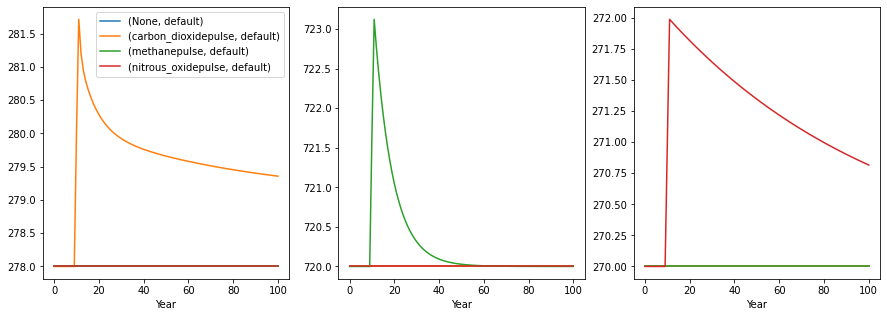

In [11]:
# Example of plotting the various scenarios against one another (also note .xs, a very handy pandas function for multi-index dataframes):

fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,gas in enumerate(['carbon_dioxide','methane','nitrous_oxide']):
    
    pulse_run['C'].xs(gas,level=-1,axis=1).plot(ax=ax[i],legend=False)
    
ax[0].legend()

## Overview of I/O structure
- The corresponding indices of each input dataframe must match or an error will occur:
    - SCENARIO in emissions_in / concentrations_in / forcing_in
    - GAS_NAMES in emissions_in / concentrations_in / gas_parameters
- If the indices of any unmatched dimensions are identical, the model will assume these dimensions are degenerate. (so if you run 3 gas parameter sets called ['high','middle','low'] with 3 thermal parameter sets called ['high','middle','low'], the model will remove one dimension & match up the sets (running 3 simulations instead of 9).

# Forcing-only example

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['bc', 'bc|aci', 'bc|bc_on_snow', 'c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'carbon_tetrachloride|o3', 'cf4', 'cfc11', 'cfc113', 'cfc113|o3', 'cfc114', 'cfc114|o3', 'cfc115', 'cfc115|o3', 'cfc11|o3', 'cfc12', 'cfc12|o3', 'ch2cl2', 'ch2cl2|o3', 'ch3ccl3', 'ch3ccl3|o3', 'chcl3', 'chcl3|o3', 'co', 'co|o3', 'halon1202', 'halon1202|o3', 'halon1211', 'halon1211|o3', 'halon1301', 'halon1301|o3', 'halon2402', 'halon2402|o3', 'hcfc141b', 'hcfc141b|o3', 'hcfc142b', 'hcfc142b|o3', 'hcfc22', 'hcfc22|o3', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc23', 'hfc236fa', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methane|strat_h2o', 'methane|o3', 'methyl_bromide', 'methyl_bromide|o3', 'methyl_chloride', 'methyl_chloride|o3', 'nf3', 'nh3', 'nitrous_oxide', 'nitrous_oxide|o3', 'nmvoc', 'nmvoc|o3', 'nox', 'nox_avi'

100%|██████████| 100/100 [00:00<00:00, 2446.70 timestep/s]


<AxesSubplot:xlabel='Year'>

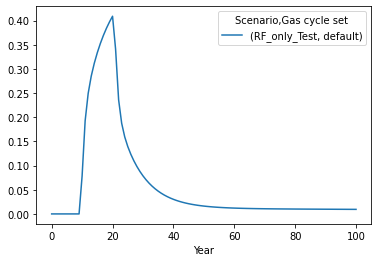

In [12]:
# A forcing-only run

RF_only_test = return_empty_forcing(start_year=0,end_year=100,scen_names=['RF_only_Test'])

## let's try a step change in RF

RF_only_test.loc[10:20]=1

RF_only_results = run_FaIR(emissions_in=return_empty_emissions(RF_only_test),forcing_in=RF_only_test)

RF_only_results['T'].plot()

# Concentration-driven example

In [13]:
# A concentration-only run

## The main bit to remember here is that FaIR is baselined at the pre-industrial concentration values!

## Let's try a 1%/yr scenario for each gas:
concentration_only_test = return_empty_emissions(df_to_copy=False, start_year=0, end_year=160, timestep=1, scen_names=[x+'_1%' for x in ['carbon_dioxide','methane','nitrous_oxide']], gases_in = ['carbon_dioxide','methane','nitrous_oxide'])

# Baseline to pre-industrial values 
# start a 1%/yr increase in year 10
for gas in ['carbon_dioxide','methane','nitrous_oxide']:
    
    concentration_only_test.loc[:,(slice(None),gas)] = get_gas_parameter_defaults().copy().loc['PI_conc',('default',gas)]
    
    concentration_only_test.loc[10:,(gas+'_1%',gas)] = concentration_only_test.loc[10,(gas+'_1%',gas)] * 1.01 ** (concentration_only_test.loc[10:].index-concentration_only_test.loc[10:].index[0])

# Run the experiment:

concentration_only_test_results = run_FaIR(concentrations_in=concentration_only_test,forcing_in=return_empty_forcing(concentration_only_test),gas_parameters=test_gas_parameters,thermal_parameters=test_thermal_parameters)

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide', 'methane', 'nitrous_oxide'] forcing agents, between 0 and 160...


100%|██████████| 160/160 [00:00<00:00, 3729.26 timestep/s]


Text(0.5, 1.0, '1%/yr concentration increase temperatures')

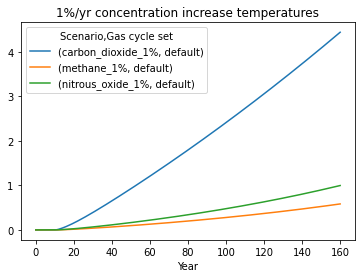

In [14]:
concentration_only_test_results['T'].plot()
plt.title('1%/yr concentration increase temperatures')

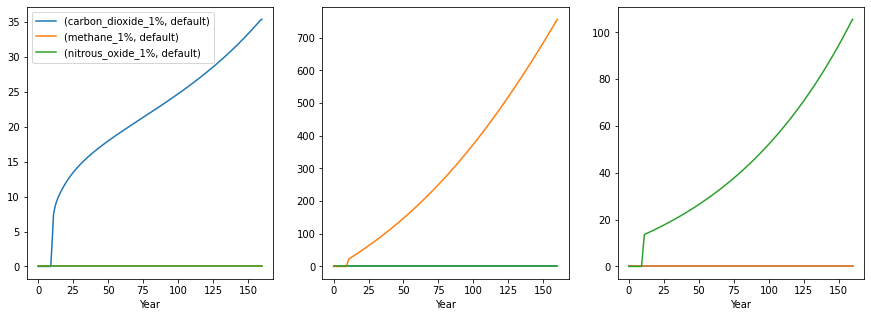

In [15]:
# By default, when a concentration run is carried out, FaIR diagnoses the corresponding emissions required to obtain those concentrations:

fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,gas in enumerate(['carbon_dioxide','methane','nitrous_oxide']):
    
    concentration_only_test_results['Emissions'].xs(gas,level=-1,axis=1).plot(ax=ax[i],legend=False)
    
ax[0].legend()

## Parameter ensembles
Much like how we can run multiple scenarios (as above) simultaneously in one run_FaIR call, we can also run multiple parameter sets by simply joining parameter dataframes together.

In [16]:
# for this example, we'll just run a single scenario with perturbed carbon cycle & climate response parameters

## perturbing cc params
base_cc_params = test_gas_parameters['default'][['carbon_dioxide']]
pert_cc_params = []
cc_param_sets = ['high_cc','medium_cc','low_cc']
cc_r_param_change = [1.13,1,0.87]

for i,cc_set in enumerate(cc_param_sets):
    
    param_set = base_cc_params.copy()
    param_set.loc[['r0','rC','rT','rA']] *= cc_r_param_change[i]
    pert_cc_params += [param_set]
    
pert_cc_params = pd.concat(pert_cc_params,axis=1,keys=cc_param_sets)

In [17]:
## perturbing climate response params
resp_param_sets = ['high_clim','medium_clim','low_clim']
ECS_vals = np.array([4.5,3,1.5])
TCR_vals = np.array([3,2,1])
RWF_vals = TCR_vals / ECS_vals

pert_resp_params = pd.concat([get_thermal_parameter_defaults(TCR=TCR_vals[i],RWF=RWF_vals[i])['default'] for i in np.arange(3)],axis=1,keys=resp_param_sets)

In [18]:
# we'll run a pulse-emission under these nine possible parameter combinations

perturbed_param_scenarios = return_empty_emissions(start_year=0,end_year=500,scen_names=['100GtC_pulse'],gases_in=['carbon_dioxide'])
perturbed_param_scenarios.iloc[1,0] = 100

perturbed_parameter_example = run_FaIR(emissions_in=perturbed_param_scenarios,
                                      gas_parameters=pert_cc_params,
                                      thermal_parameters=pert_resp_params)

Integrating 1 scenarios, 3 gas cycle parameter sets, 3 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 500...


100%|██████████| 500/500 [00:00<00:00, 2523.00 timestep/s]


In [19]:
## example of what the output looks like:
perturbed_parameter_example['T'].head()

Scenario      100GtC_pulse                                              \
Gas cycle set      high_cc                       medium_cc               
Thermal set      high_clim medium_clim  low_clim high_clim medium_clim   
Year                                                                     
0                 0.000000    0.000000  0.000000  0.000000    0.000000   
1                 0.038831    0.032129  0.025426  0.037414    0.030956   
2                 0.130400    0.105656  0.080916  0.124783    0.101091   
3                 0.207261    0.162486  0.117734  0.196557    0.154014   
4                 0.246013    0.185625  0.125293  0.231700    0.174668   

Scenario                                                 
Gas cycle set              low_cc                        
Thermal set    low_clim high_clim medium_clim  low_clim  
Year                                                     
0              0.000000  0.000000    0.000000  0.000000  
1              0.024498  0.035743    0.029573  0.023404  
2              0.077402  0.118597    0.096070  0.073547  
3              0.111490  0.185571    0.145352  0.105147  
4              0.117681  0.217613    0.163937  0.110298

Text(0.5, 1.0, 'Year 1 100GtC pulse temperature response under a range of carbon-cycle & climate response parameters')

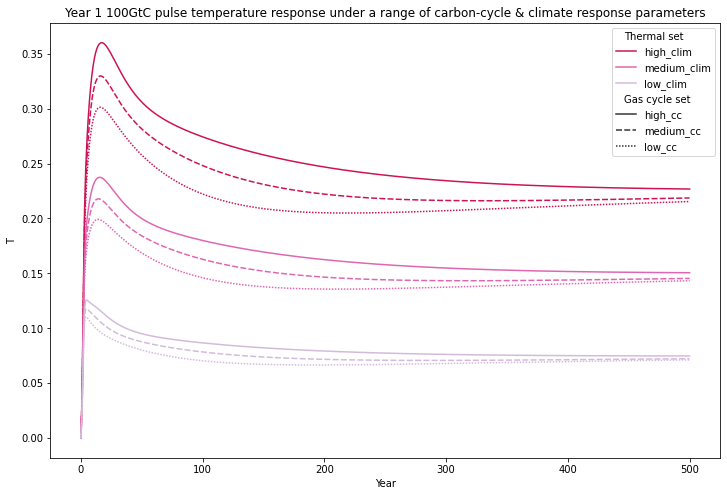

In [20]:
# here I'll just show how seaborn can give useful visualisations from FaIR output
fig,ax = plt.subplots(figsize=(12,8))
g=sn.lineplot(data=perturbed_parameter_example['T'].unstack().reset_index().rename({0:'T'},axis=1),
              x='Year',y='T',
              hue='Thermal set',
              style='Gas cycle set',
              palette='PuRd_r',
              ax=ax)

plt.title('Year 1 100GtC pulse temperature response under a range of carbon-cycle & climate response parameters')

# End of example notebook
There are additional features (eg. variable timestepping) that could be included at this point, but they are less supported and will not be used in other notebooks in this repository.